In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
num_data = pd.read_csv('Numbers.txt', sep=' ')
print(num_data.head())

   V1   V2   V3   V4     V5     V6     V7     V8     V9    V10  ...   V248  \
1   0 -1.0 -1.0 -1.0 -1.000 -1.000 -0.972  0.178  1.000  0.689  ...  0.522   
2   9 -1.0 -1.0 -1.0 -1.000 -1.000 -0.815  0.268  0.640  0.869  ... -0.090   
3   8 -1.0 -1.0 -1.0 -1.000 -0.987 -0.806 -0.169  0.350  0.986  ...  0.873   
4  -9 -1.0 -1.0 -1.0 -1.000 -1.000 -1.000 -0.851  0.668 -0.858  ...  0.832   
5   8 -1.0 -1.0 -1.0 -0.928  0.162 -0.014 -0.210  0.999  1.000  ... -1.000   

    V249   V250   V251   V252   V253  V254  V255  V256  V257  
1  0.940  1.000  0.400 -0.337 -0.954  -1.0  -1.0  -1.0  -1.0  
2  0.990 -0.381 -1.000 -1.000 -1.000  -1.0  -1.0  -1.0  -1.0  
3  1.000  1.000  0.832  0.196 -0.714  -1.0  -1.0  -1.0  -1.0  
4 -0.017 -0.847 -1.000 -1.000 -1.000  -1.0  -1.0  -1.0  -1.0  
5 -0.683  0.711  1.000  0.320 -0.928  -1.0  -1.0  -1.0  -1.0  

[5 rows x 257 columns]


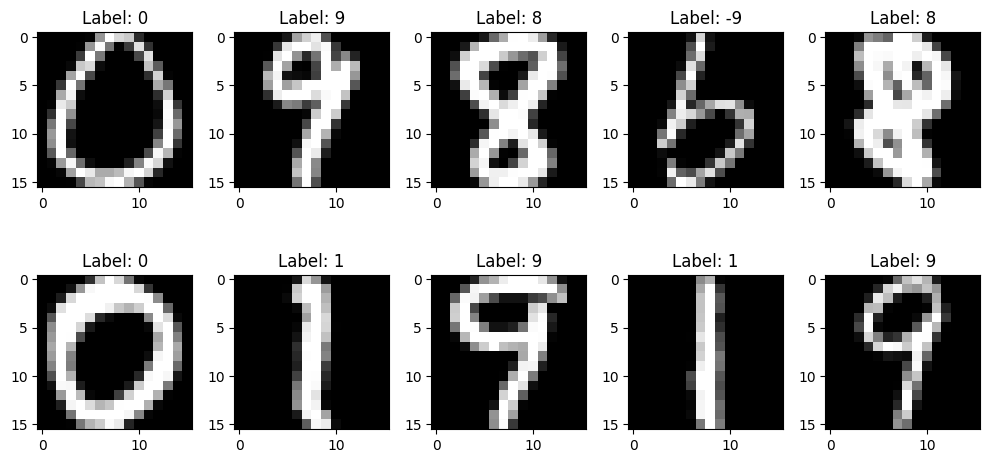

In [3]:
labels = num_data.iloc[:, 0].values
pixels = num_data.iloc[:, 1:].values

# Plotting multiple images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(pixels[i].reshape(16, 16), cmap='gray')
    ax.set_title(f'Label: {labels[i]}')
plt.tight_layout()
plt.show()

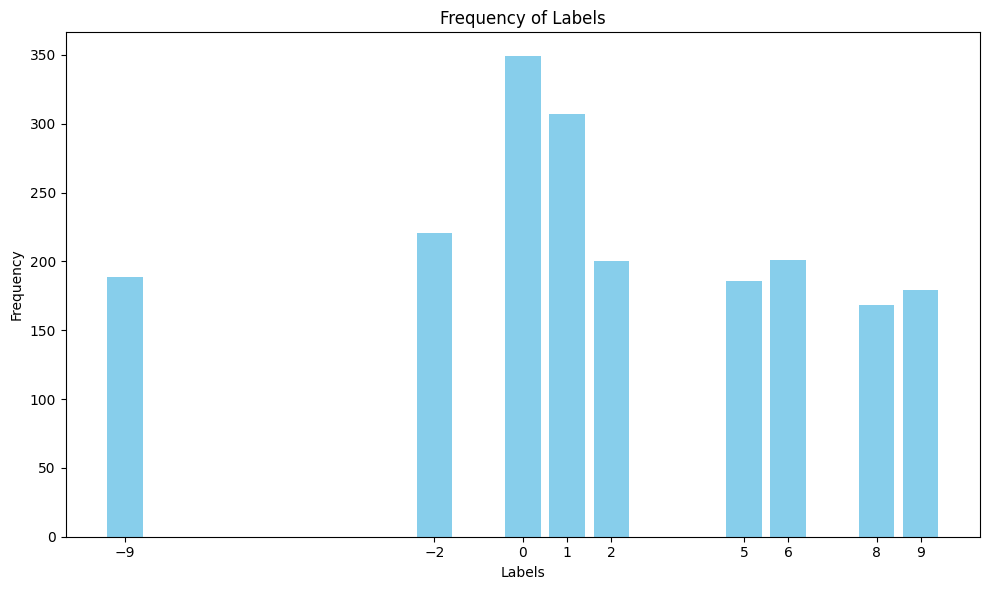

In [4]:
unique_labels, counts = np.unique(labels, return_counts=True)

# Plot the frequency of each label
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Labels')
plt.xticks(unique_labels)  # Ensure all labels are shown on the x-axis
plt.tight_layout()
plt.show()

## Part 1: explore at least 3 different classifiers of different character

In this task, we choose 4 different classifiers:

- K-Nearest Neighbors (KNN) Classifier
- Logistic Regression Classifier
- Random Forest Classifier
- Linear Discriminant Analysis (LDA) Classifier


1. **Perform cross-validation to compare the different models without tuning.**

KNeighborsClassifier CV Mean Score: 0.9205 ± 0.0110
LogisticRegression CV Mean Score: 0.9180 ± 0.0075
RandomForestClassifier CV Mean Score: 0.9310 ± 0.0123
LinearDiscriminantAnalysis CV Mean Score: 0.8895 ± 0.0091


C:\Users\Kay Yan\AppData\Local\Temp\ipykernel_38468\1106754608.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([models_scores[0,:], models_scores[1,:], models_scores[2,:], models_scores[3,:]], labels=['kNN', 'LogReg', 'RandFor', 'LDA'])


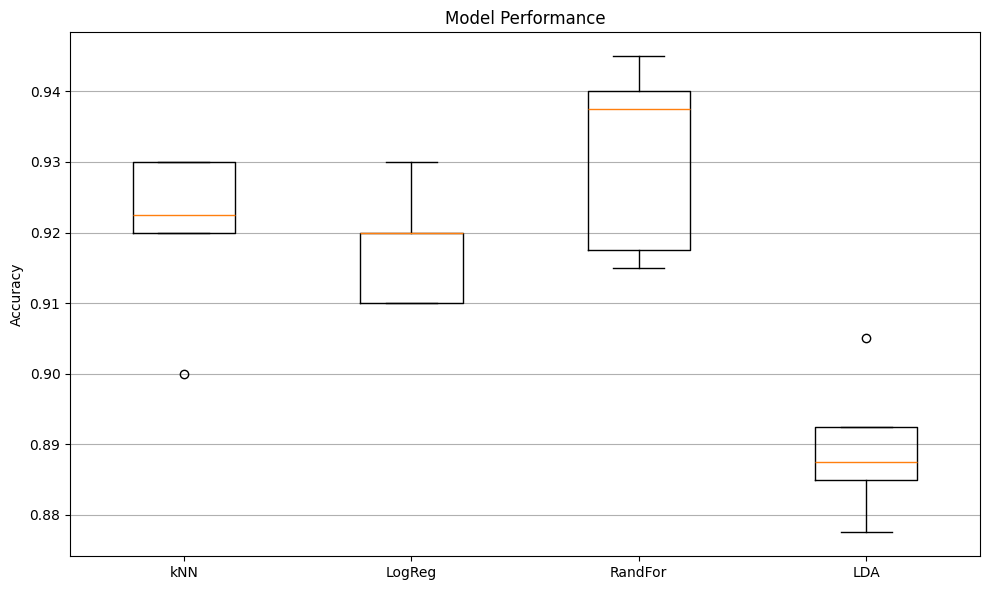

In [5]:
models = [
    KNeighborsClassifier(),
    LogisticRegression(),
    RandomForestClassifier(),
    LinearDiscriminantAnalysis()
]

model_names = []
mean_scores = []
std_devs = []
models_scores = np.zeros((len(models), 5))

for model in models:
    cv_scores = cross_val_score(model, pixels, labels, cv=5)
    print(f"{model.__class__.__name__} CV Mean Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    model_names.append(model.__class__.__name__)
    mean_scores.append(cv_scores.mean())
    std_devs.append(cv_scores.std())
    models_scores[len(model_names) - 1] =cv_scores

plt.figure(figsize=(10, 6))
plt.boxplot([models_scores[0,:], models_scores[1,:], models_scores[2,:], models_scores[3,:]], labels=['kNN', 'LogReg', 'RandFor', 'LDA'])
plt.title("Model Performance")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

2. **Perform cross-validation to tune *and* compare the different models.**

In [10]:
def double_CV(X, y, model, param_grid):
    """
    Perform double cross-validation for hyperparameter tuning and model evaluation.
    
    Parameters:
    - X: pixels (features)
    - y: labels
    - model: The classifier model to evaluate
    - param_grid: Dictionary of hyperparameters to tune
    
    Returns:
    - mean_test_score: Mean test score across outer folds
    """
    # Outer cross-validation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    training_errors = []
    cv_errors = []
    test_errors = []
    
    for train_idx, test_idx in outer_cv.split(X, y):
        # Split the data into training and testing sets
        X_train_outer, X_test_outer = X[train_idx], X[test_idx]
        y_train_outer, y_test_outer = y[train_idx], y[test_idx]
        
        # Perform inner cross-validation for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1, return_train_score=True)
        grid_search.fit(X_train_outer, y_train_outer)
        
        # Print the best parameters and the corresponding score
        best_index = grid_search.best_index_
        training_error = 1 - grid_search.cv_results_['mean_train_score'][best_index]
        cv_score = 1 - grid_search.cv_results_['mean_test_score'][best_index]
        training_errors.append(training_error)
        cv_errors.append(cv_score)

        best_params = grid_search.best_params_
        print(f"Best Params for Fold: {best_params}")
        
        # Train the model with the best parameters on the outer training set
        if model.__class__ == LogisticRegression:
            best_params['max_iter'] = 1000
        best_model = model.__class__(**best_params)
        best_model.fit(X_train_outer, y_train_outer)

        # Evaluate the model on the outer test set
        test_accuracy = best_model.score(X_test_outer, y_test_outer)
        test_error = 1 - test_accuracy
        test_errors.append(test_error)

    print(f"Training Errors: {training_errors}")
    print(f"CV Errors: {cv_errors}")
    print(f"Test Errors: {test_errors}")
    print(f"Mean Test Error: {np.mean(test_errors):.4f} ± {np.std(test_errors):.4f}")

    # Plotting the distribution of errors
    plt.figure(figsize=(8, 6))
    plt.boxplot([training_errors, cv_errors, test_errors], labels=['Training Error', 'CV Error', 'Test Error'])
    plt.title("Error Distribution for model " + model.__class__.__name__)
    plt.ylim(0, 0.15)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.ylabel("Error")
    plt.show()

    return np.mean(test_errors), np.std(test_errors)


Evaluating KNeighborsClassifier...
Best Params for Fold: {'n_neighbors': 1}
Best Params for Fold: {'n_neighbors': 3}
Best Params for Fold: {'n_neighbors': 3}
Best Params for Fold: {'n_neighbors': 5}
Best Params for Fold: {'n_neighbors': 3}
Training Errors: [np.float64(0.0), np.float64(0.03734375000000012), np.float64(0.04125000000000012), np.float64(0.05265625000000007), np.float64(0.04093750000000007)]
CV Errors: [np.float64(0.07187500000000002), np.float64(0.07125000000000004), np.float64(0.07437500000000008), np.float64(0.08062500000000006), np.float64(0.07562499999999994)]
Test Errors: [0.06499999999999995, 0.07999999999999996, 0.08499999999999996, 0.06499999999999995, 0.07750000000000001]
Mean Test Error: 0.0745 ± 0.0081


C:\Users\Kay Yan\AppData\Local\Temp\ipykernel_38468\1666612354.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([training_errors, cv_errors, test_errors], labels=['Training Error', 'CV Error', 'Test Error'])


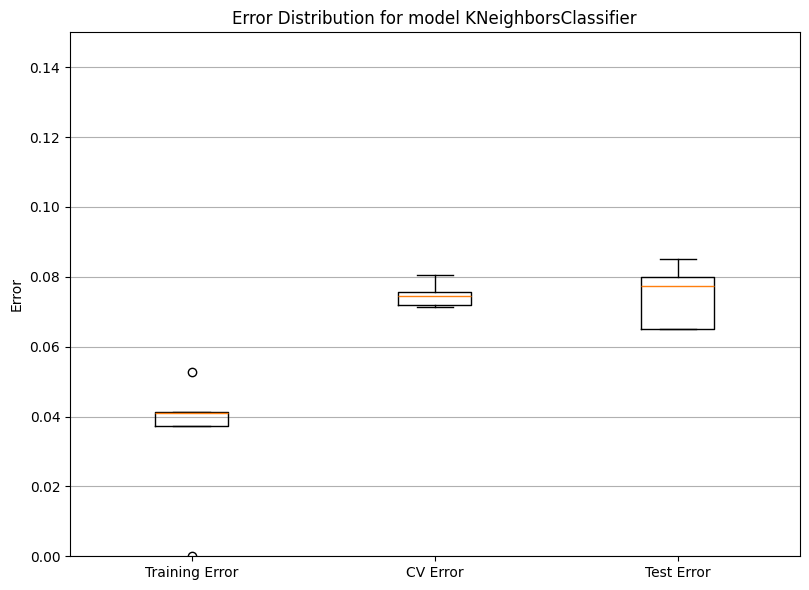

Evaluating LogisticRegression...
Best Params for Fold: {'C': 0.1}
Best Params for Fold: {'C': 0.1}
Best Params for Fold: {'C': 0.1}
Best Params for Fold: {'C': 0.1}
Best Params for Fold: {'C': 0.1}
Training Errors: [np.float64(0.020312499999999956), np.float64(0.01734374999999999), np.float64(0.01734374999999988), np.float64(0.01578125000000008), np.float64(0.01593750000000005)]
CV Errors: [np.float64(0.07999999999999985), np.float64(0.08125000000000004), np.float64(0.07750000000000001), np.float64(0.08125000000000004), np.float64(0.08250000000000013)]
Test Errors: [0.07499999999999996, 0.09250000000000003, 0.07999999999999996, 0.07750000000000001, 0.06999999999999995]
Mean Test Error: 0.0790 ± 0.0075


C:\Users\Kay Yan\AppData\Local\Temp\ipykernel_38468\1666612354.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([training_errors, cv_errors, test_errors], labels=['Training Error', 'CV Error', 'Test Error'])


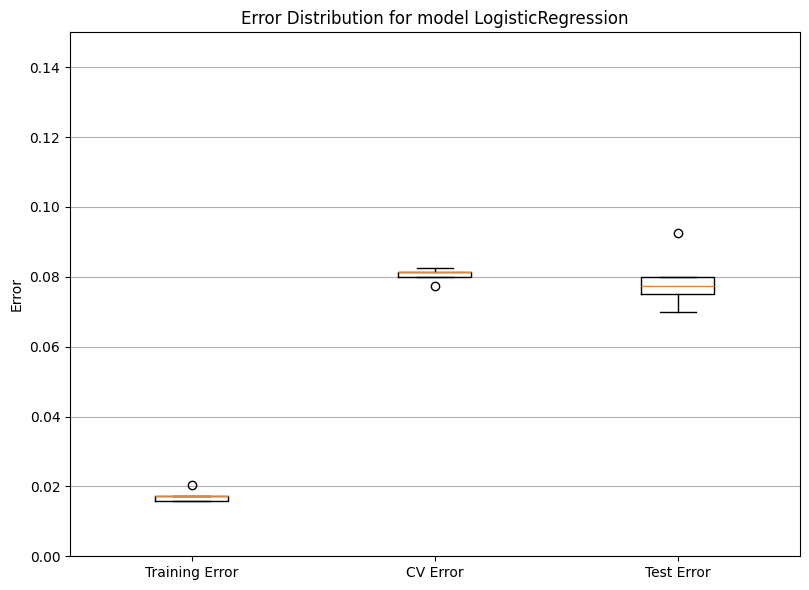

Evaluating RandomForestClassifier...
Best Params for Fold: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Params for Fold: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Params for Fold: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best Params for Fold: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best Params for Fold: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Training Errors: [np.float64(0.0), np.float64(0.0), np.float64(0.0006249999999999867), np.float64(0.0), np.float64(0.0)]
CV Errors: [np.float64(0.0668749999999999), np.float64(0.06624999999999992), np.float64(0.06374999999999997), np.float64(0.0674999999999999), np.float64(0.06812499999999999)]
Test Errors: [0.0675, 0.07750000000000001, 0.08250000000000002, 0.050000000000000044, 0.05500000000000005]
Mean Test Error: 0.0665 ± 0.0125


C:\Users\Kay Yan\AppData\Local\Temp\ipykernel_38468\1666612354.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([training_errors, cv_errors, test_errors], labels=['Training Error', 'CV Error', 'Test Error'])


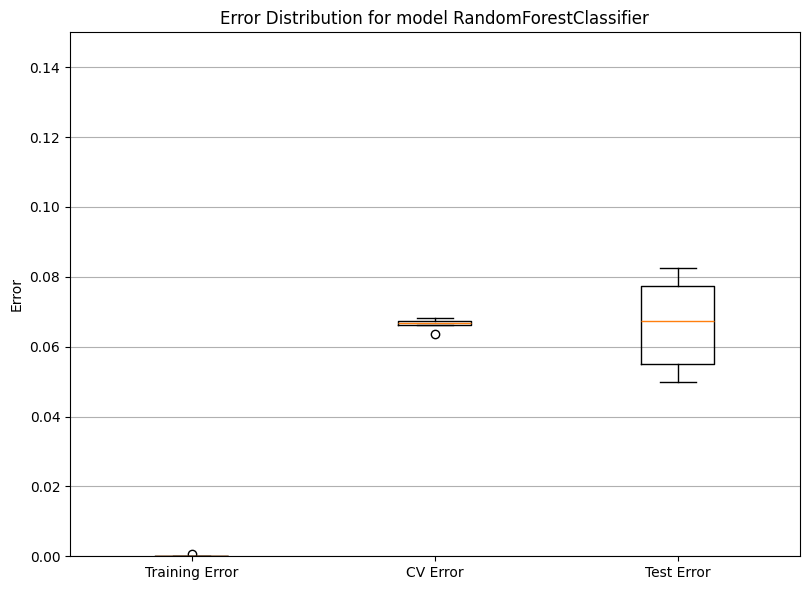

Evaluating LinearDiscriminantAnalysis...
Best Params for Fold: {'solver': 'svd'}
Best Params for Fold: {'solver': 'svd'}
Best Params for Fold: {'solver': 'svd'}
Best Params for Fold: {'solver': 'svd'}
Best Params for Fold: {'solver': 'svd'}
Training Errors: [np.float64(0.03749999999999998), np.float64(0.03937499999999994), np.float64(0.03453125000000001), np.float64(0.03953124999999991), np.float64(0.03843750000000001)]
CV Errors: [np.float64(0.1293749999999999), np.float64(0.11187500000000006), np.float64(0.11562499999999998), np.float64(0.12249999999999994), np.float64(0.1187499999999998)]
Test Errors: [0.10250000000000004, 0.13, 0.11499999999999999, 0.08999999999999997, 0.10999999999999999]
Mean Test Error: 0.1095 ± 0.0133


C:\Users\Kay Yan\AppData\Local\Temp\ipykernel_38468\1666612354.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([training_errors, cv_errors, test_errors], labels=['Training Error', 'CV Error', 'Test Error'])


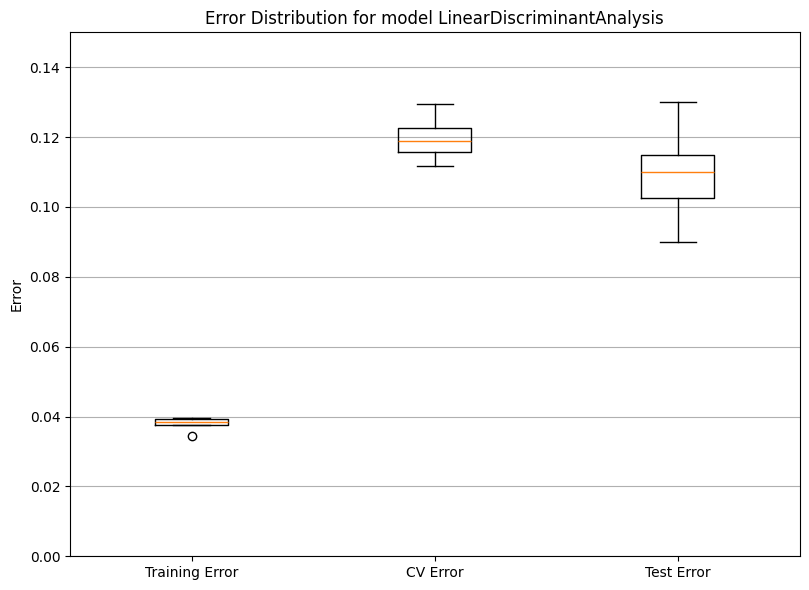

In [11]:
models = [
    KNeighborsClassifier(),
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(),
    LinearDiscriminantAnalysis()
]

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],     # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split an internal node
}
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength            # Regularization type
}
param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],    # Algorithm to use for LDA
}
param_grid_knn = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Number of neighbors to use
}
param_grids = {
    KNeighborsClassifier: param_grid_knn,
    LogisticRegression: param_grid_lr,
    RandomForestClassifier: param_grid_rf,
    LinearDiscriminantAnalysis: param_grid_lda
}

classifiers_test_errors = {}
for model in models:
    print(f"Evaluating {model.__class__.__name__}...")
    param_grid = param_grids[model.__class__]
    classifiers_test_errors[model.__class__.__name__] = double_CV(pixels, labels, model, param_grid)

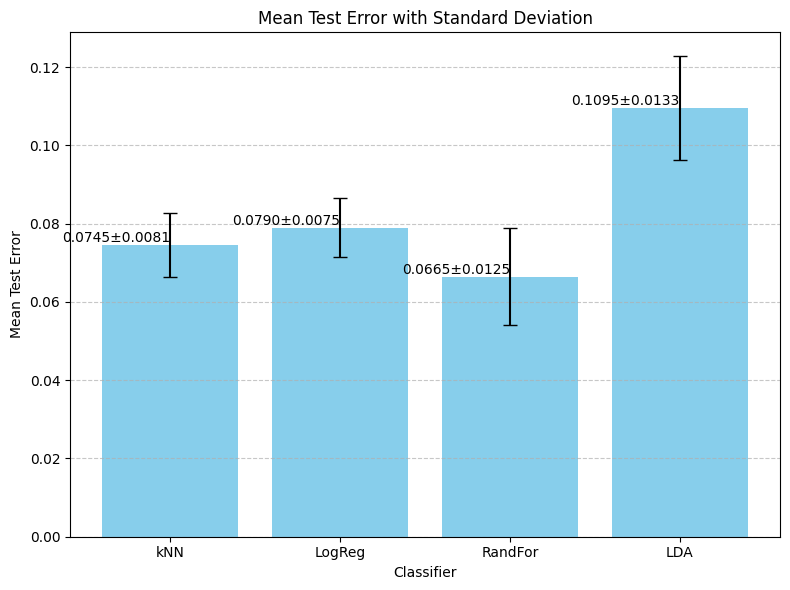

In [12]:
plt.figure(figsize=(8, 6))
plt.bar(classifiers_test_errors.keys(), [v[0] for v in classifiers_test_errors.values()], yerr=[v[1] for v in classifiers_test_errors.values()], capsize=5, color='skyblue')
plt.xlabel('Classifier')
plt.ylabel('Mean Test Error')
plt.xticks(ticks=range(len(['kNN', 'LogReg', 'RandFor', 'LDA'])), labels=['kNN', 'LogReg', 'RandFor', 'LDA'])
plt.title('Mean Test Error with Standard Deviation')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

for i in range(len(classifiers_test_errors)):
    mean = classifiers_test_errors[list(classifiers_test_errors.keys())[i]][0]
    std = classifiers_test_errors[list(classifiers_test_errors.keys())[i]][1]
    plt.text(i, mean, f'{mean:.4f}±{std:.4f}' , ha='right', va='bottom', fontsize=10, color='black')

plt.show()

